## Addressing assumptions

In logistic regression, there are a few assumptions that must be considered.  
 - For this evaluation, we determined that we are solving for a binary classification of 'Violent' and 'Non-Violent' crimes.  In binary classification, the dependent variable must be binary; we must only have two outcomes. 
 - The second assumption to consider is independence.  The dataset may not use a method such as repeated measures.  Our dataset, as far as we understand, has measured unique, independent crime activities.
 - The third assumption or requirement is that the selected data must have little or no multicollinearity among the variables.  During our Exploratory Data Analysis, we did identify that we had correlation between months and temperature data.  We did not include the weather data in this modeling.  
 - A final requirement for logistic regression is a 'large' sample size.  At an original dataset of 1.4M observations, we comfortably met this metric.

## Setting Up the Data

In [74]:
import pandas as pd
import numpy as np

In [75]:
crime = pd.read_csv('Training_and_Test_Set.csv') # read in the csv %%file

In [76]:
crime.dtypes

JURIS_DESC            object
BORO_NM               object
ADDR_PCT_CD          float64
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
Day_Name              object
Duration             float64
Duration_to_PD       float64
Month                 object
Day                  float64
Year                 float64
Duration_lbl          object
Season                object
Daytime               object
GeoCell              float64
GeoCell_X            float64
GeoCell_Y            float64
y                      int64
dtype: object

In [77]:
crime.head()

,JURIS_DESC,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,Day_Name,Duration,Duration_to_PD,Month,Day,Year,Duration_lbl,Season,Daytime,GeoCell,GeoCell_X,GeoCell_Y,y
0,N.Y. POLICE DEPT,STATEN ISLAND,120.0,INSIDE,COMMERCIAL BUILDING,Friday,3.0,0.0,September,5.0,2014.0,Short,Fall,Morning,23.0,3.0,3.0,0
1,N.Y. POLICE DEPT,STATEN ISLAND,121.0,INSIDE,RESIDENCE-HOUSE,Sunday,1.0,0.0,December,27.0,2015.0,Short,Winter,Day,23.0,3.0,3.0,1
2,N.Y. POLICE DEPT,BRONX,43.0,INSIDE,RESIDENCE - APT. HOUSE,Sunday,14.0,171.0,September,1.0,2013.0,Medium,Fall,Night,78.0,8.0,8.0,0
3,N.Y. POLICE DEPT,BROOKLYN,75.0,INSIDE,RESIDENCE-HOUSE,Friday,6.0,28.0,October,10.0,2014.0,Short,Fall,Day,47.0,7.0,5.0,0
4,N.Y. POLICE DEPT,MANHATTAN,6.0,FRONT OF,STREET,Sunday,1.0,0.0,September,28.0,2014.0,Short,Fall,Early Morning,55.0,5.0,6.0,0


In [78]:
### This was all done as part of the data prep and is now 'y' in the dataset

#Create categorical list of all 68 possible offenses
#4 types of crime: Personal, Property, Statutory/State, and Other

#Personal - Assault, Battery, Abuse, Kidnapping, Rape, Homicide, Harrassment
#personal_list = ['ASSAULT', 'BATTERY', 'MURDER', 'MANSLAUGHTER', 'HARRASSMENT', 'KIDNAPPING', 'RAPE', 'SEX', 'HOMICIDE', 'WEAPON', 'WEAPONS', 'PERSON']

#Property - Arson, Theft, Mischief, Burglary, Larceny, Robbery, Forgery, Embezzlement, Shoplifting, Trespass, Fraud/Financial
#property_list = ['ARSON', 'THEFT', 'THEF', 'MISCHIEF', 'ROBBERY', 'BURGLARY', 'JOSTLING', 'TOOLS', 'FRAUD', 'FRAUDS', 'FRAUDULENT', 'LARCENY', 'FORGERY', 'STOLEN', 'UNAUTHORIZED', 'TRESPASS']

#Statutory - State-Related offenses, DUI, DWI, Gambling, Loitering, Drug, Traffic, Public Servant/Admin-related crimes
#statutory_list = ['DRUGS', 'DRUG', 'SENSBLTY', 'PENAL', 'PUBLIC', 'INTOXICATED', 'TRAFFIC', 'ADMINISTRATIVE', 'GAMBLING', 'PROSTITUTION', 'ALCOHOLIC', 'DISORDERLY']

#Violent vs Non-Violent
#violent = personal_list
#non_violent = property_list + statutory_list

In [79]:
#Value Counts by Crime Type
crime['y'].value_counts()

0    365333
1    163540
Name: y, dtype: int64

In [80]:
#dropping any remaining NANs
crime = crime.dropna() 

In [81]:
crime.isnull().values.any()

False

In [82]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528873 entries, 0 to 528872
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   JURIS_DESC         528873 non-null  object 
 1   BORO_NM            528873 non-null  object 
 2   ADDR_PCT_CD        528873 non-null  float64
 3   LOC_OF_OCCUR_DESC  528873 non-null  object 
 4   PREM_TYP_DESC      528873 non-null  object 
 5   Day_Name           528873 non-null  object 
 6   Duration           528873 non-null  float64
 7   Duration_to_PD     528873 non-null  float64
 8   Month              528873 non-null  object 
 9   Day                528873 non-null  float64
 10  Year               528873 non-null  float64
 11  Duration_lbl       528873 non-null  object 
 12  Season             528873 non-null  object 
 13  Daytime            528873 non-null  object 
 14  GeoCell            528873 non-null  float64
 15  GeoCell_X          528873 non-null  float64
 16  Ge

In [83]:
# replace the current Violent Crime classification atribute with something slightly more intuitive and readable
#crime['NonViolent'] = crime.OFNS_DESC_TYPE=='Non-Violent Crime' 
#crime.NonViolent = crime.NonViolent.astype(np.int)

In [84]:
# perform one-hot encoding of the categorical data on 'JURIS_DESC','BORO_NM','LOC_OF_OCCUR_DESC',
#'ADDR_PCT_CD','PREM_TYP_DESC','Day_Name','Month','Duration_lbl','Season','Daytime'
tmp_df = pd.get_dummies(crime.JURIS_DESC,prefix='JURIS_DESC')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.BORO_NM,prefix='BORO_NM')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.LOC_OF_OCCUR_DESC,prefix='LOC_OF_OCCUR_DESC')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.ADDR_PCT_CD,prefix='ADDR_PCT_CD')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.PREM_TYP_DESC,prefix='PREM_TYP_DESC')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Day_Name,prefix='Day_Name')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Month,prefix='Month')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Duration_lbl,prefix='Duration_lbl')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Season,prefix='Season')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Daytime,prefix='Daytime')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

In [85]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528873 entries, 0 to 528872
Columns: 225 entries, JURIS_DESC to Daytime_Night
dtypes: float64(8), int64(1), object(9), uint8(207)
memory usage: 181.1+ MB


In [86]:
#Now we drop the original variables
if 'JURIS_DESC' in crime:    
    del crime['JURIS_DESC'] # get rid of the original category as it is now one-hot encoded
if 'BORO_NM' in crime:    
    del crime['BORO_NM'] # get rid of the original category as it is now one-hot encoded
if 'LOC_OF_OCCUR_DESC' in crime:    
    del crime['LOC_OF_OCCUR_DESC'] # get rid of the original category as it is now one-hot encoded
if 'ADDR_PCT_CD' in crime:    
    del crime['ADDR_PCT_CD'] # get rid of the original category as it is now one-hot encoded
if 'PREM_TYP_DESC' in crime:    
    del crime['PREM_TYP_DESC'] # get rid of the original category as it is now one-hot encoded
if 'Day_Name' in crime:    
    del crime['Day_Name'] # get rid of the original category as it is now one-hot encoded
if 'Month' in crime:    
    del crime['Month'] # get rid of the original category as it is now one-hot encoded
if 'Duration_lbl' in crime:    
    del crime['Duration_lbl'] # get rid of the original category as it is now one-hot encoded
if 'Season' in crime:    
    del crime['Season'] # get rid of the original category as it is now one-hot encoded
if 'Daytime' in crime:    
    del crime['Daytime'] # get rid of the original category as it is now one-hot encoded

In [87]:
pd.set_option('display.max_rows', 300)
crime.dtypes

Duration                                      float64
Duration_to_PD                                float64
Day                                           float64
Year                                          float64
GeoCell                                       float64
GeoCell_X                                     float64
GeoCell_Y                                     float64
y                                               int64
JURIS_DESC_AMTRACK                              uint8
JURIS_DESC_DEPT OF CORRECTIONS                  uint8
JURIS_DESC_HEALTH & HOSP CORP                   uint8
JURIS_DESC_LONG ISLAND RAILRD                   uint8
JURIS_DESC_METRO NORTH                          uint8
JURIS_DESC_N.Y. HOUSING POLICE                  uint8
JURIS_DESC_N.Y. POLICE DEPT                     uint8
JURIS_DESC_N.Y. STATE PARKS                     uint8
JURIS_DESC_N.Y. STATE POLICE                    uint8
JURIS_DESC_N.Y. TRANSIT POLICE                  uint8
JURIS_DESC_NEW YORK CITY SHE

In [88]:
#Balancing the Dataset

In [89]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'y' in crime:
    y = crime['y'].values # get the labels we want
    del crime['y'] # get rid of the class label
    X = crime.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn

In [90]:
from imblearn.over_sampling import SMOTE
#transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

## Logistic Regression Model 1

In [91]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [92]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.719900912860799
confusion matrix
 [[46245 26972]
 [13960 58957]]
====Iteration 1  ====
accuracy 0.720263593687985
confusion matrix
 [[46461 26725]
 [14154 58794]]
====Iteration 2  ====
accuracy 0.7206810187909727
confusion matrix
 [[46307 26798]
 [14020 59009]]


In [93]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.7209273680320801
confusion matrix
 [[46225 26476]
 [14306 59127]]
====Iteration 1  ====
accuracy 0.7206331175496462
confusion matrix
 [[46166 26717]
 [14108 59143]]
====Iteration 2  ====
accuracy 0.7210300135492083
confusion matrix
 [[46245 26726]
 [14041 59122]]


In [94]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.72248758 0.7198667  0.72070839]


In [95]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None,solver='liblinear') # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=2.451, description='cost', max=5.0, min=0.001, step=0.05), Output()), …

<function __main__.lr_explor(cost)>

In [96]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = crime.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

Duration has weight of -0.362527823792849
Duration_to_PD has weight of -6.598342251022148e-05
Day has weight of 2.4525373487405154e-06
Year has weight of 0.0011126476220496967
GeoCell has weight of 0.04940958527848923
GeoCell_X has weight of -0.036482780512826225
GeoCell_Y has weight of -0.4754070104671924
JURIS_DESC_AMTRACK has weight of -0.03961610261727986
JURIS_DESC_DEPT OF CORRECTIONS has weight of 0.05120416098421587
JURIS_DESC_HEALTH & HOSP CORP has weight of 0.7540828558383644
JURIS_DESC_LONG ISLAND RAILRD has weight of 0.009101112929555217
JURIS_DESC_METRO NORTH has weight of 0.7638533227632698
JURIS_DESC_N.Y. HOUSING POLICE has weight of 0.19951019641191525
JURIS_DESC_N.Y. POLICE DEPT has weight of 0.3050703914004204
JURIS_DESC_N.Y. STATE PARKS has weight of 0.23332819863393178
JURIS_DESC_N.Y. STATE POLICE has weight of -0.34419921641779905
JURIS_DESC_N.Y. TRANSIT POLICE has weight of -0.48933988471501777
JURIS_DESC_NEW YORK CITY SHERIFF OFFICE has weight of -0.01891841541779

In [97]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,crime.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.7202156924466585
[[46250 26855]
 [14031 58998]]
Duration has weight of -1.7363532368038321
PREM_TYP_DESC_DEPARTMENT STORE has weight of -0.411783894778442
Duration_lbl_Short has weight of -0.3916694103663207
PREM_TYP_DESC_CHAIN STORE has weight of -0.32523055432021136
PREM_TYP_DESC_DRUG STORE has weight of -0.24061219782369303
PREM_TYP_DESC_CLOTHING/BOUTIQUE has weight of -0.23946277669683977
LOC_OF_OCCUR_DESC_OPPOSITE OF has weight of -0.1630768140041907
LOC_OF_OCCUR_DESC_REAR OF has weight of -0.15380552277700418
PREM_TYP_DESC_FOOD SUPERMARKET has weight of -0.13961480760765413
PREM_TYP_DESC_BANK has weight of -0.10684510430083687
PREM_TYP_DESC_GYM/FITNESS FACILITY has weight of -0.10319444309961609
PREM_TYP_DESC_COMMERCIAL BUILDING has weight of -0.10287331493435503
PREM_TYP_DESC_ATM has weight of -0.09086603419642837
PREM_TYP_DESC_TELECOMM. STORE has weight of -0.07222435117211018
PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE) has weight of -0.06966892429587168
PREM_TYP_DES

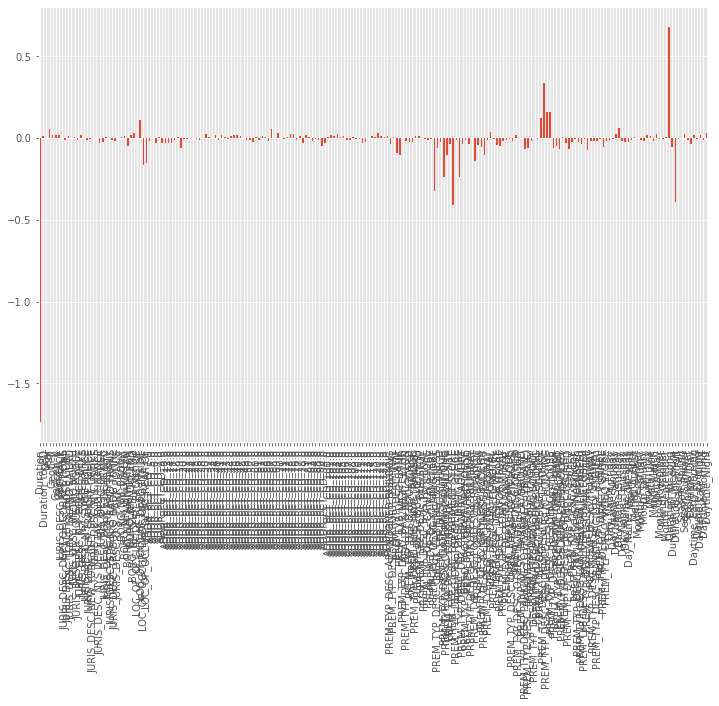

In [98]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=crime.columns)
weights.plot(kind='bar', figsize = (12,8))
plt.show()

In [99]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import *
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     73105
           1       0.69      0.81      0.74     73029

    accuracy                           0.72    146134
   macro avg       0.73      0.72      0.72    146134
weighted avg       0.73      0.72      0.72    146134



In [26]:
zip_vars

[(array([-1.73178314]), 'Duration'),
 (array([-0.41382134]), 'PREM_TYP_DESC_DEPARTMENT STORE'),
 (array([-0.38792136]), 'Duration_lbl_Short'),
 (array([-0.33161099]), 'PREM_TYP_DESC_CHAIN STORE'),
 (array([-0.23919391]), 'PREM_TYP_DESC_CLOTHING/BOUTIQUE'),
 (array([-0.23649728]), 'PREM_TYP_DESC_DRUG STORE'),
 (array([-0.16066581]), 'LOC_OF_OCCUR_DESC_OPPOSITE OF'),
 (array([-0.15575017]), 'LOC_OF_OCCUR_DESC_REAR OF'),
 (array([-0.14337561]), 'PREM_TYP_DESC_FOOD SUPERMARKET'),
 (array([-0.10479462]), 'PREM_TYP_DESC_COMMERCIAL BUILDING'),
 (array([-0.10144901]), 'PREM_TYP_DESC_GYM/FITNESS FACILITY'),
 (array([-0.10010755]), 'PREM_TYP_DESC_BANK'),
 (array([-0.0918653]), 'PREM_TYP_DESC_ATM'),
 (array([-0.07017901]), 'PREM_TYP_DESC_TELECOMM. STORE'),
 (array([-0.06935909]), 'PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE)'),
 (array([-0.06731994]), 'PREM_TYP_DESC_STORE UNCLASSIFIED'),
 (array([-0.06378223]), 'PREM_TYP_DESC_RESTAURANT/DINER'),
 (array([-0.06232652]), 'PREM_TYP_DESC_SMALL MERCHANT

## Logistic Regression Model 2

For the next iteration of the model evaluation, we are using a subset of variables based on an importance threshold set at |.03| from the initial model created

In [27]:
import pandas as pd
import numpy as np

In [28]:
crime = pd.read_csv('Training_and_Test_Set.csv') # read in the csv %%file

In [29]:
crime.dtypes #data check that it read in correctly

JURIS_DESC            object
BORO_NM               object
ADDR_PCT_CD          float64
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
Day_Name              object
Duration             float64
Duration_to_PD       float64
Month                 object
Day                  float64
Year                 float64
Duration_lbl          object
Season                object
Daytime               object
GeoCell              float64
GeoCell_X            float64
GeoCell_Y            float64
y                      int64
dtype: object

In [30]:
#Value Counts by Crime Type
crime['y'].value_counts()

0    365333
1    163540
Name: y, dtype: int64

In [31]:
#dropping any remaining NANs
crime = crime.dropna() 

In [32]:
crime.isnull().values.any()

False

In [34]:
# perform one-hot encoding of the categorical data on 'JURIS_DESC','BORO_NM','LOC_OF_OCCUR_DESC',
#'ADDR_PCT_CD','PREM_TYP_DESC','Day_Name','Month','Duration_lbl','Season','Daytime'
tmp_df = pd.get_dummies(crime.JURIS_DESC,prefix='JURIS_DESC')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.BORO_NM,prefix='BORO_NM')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.LOC_OF_OCCUR_DESC,prefix='LOC_OF_OCCUR_DESC')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.ADDR_PCT_CD,prefix='ADDR_PCT_CD')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.PREM_TYP_DESC,prefix='PREM_TYP_DESC')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Day_Name,prefix='Day_Name')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Month,prefix='Month')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Duration_lbl,prefix='Duration_lbl')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Season,prefix='Season')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Daytime,prefix='Daytime')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

In [35]:
#Now we drop the original variables
if 'JURIS_DESC' in crime:    
    del crime['JURIS_DESC'] # get rid of the original category as it is now one-hot encoded
if 'BORO_NM' in crime:    
    del crime['BORO_NM'] # get rid of the original category as it is now one-hot encoded
if 'LOC_OF_OCCUR_DESC' in crime:    
    del crime['LOC_OF_OCCUR_DESC'] # get rid of the original category as it is now one-hot encoded
if 'ADDR_PCT_CD' in crime:    
    del crime['ADDR_PCT_CD'] # get rid of the original category as it is now one-hot encoded
if 'PREM_TYP_DESC' in crime:    
    del crime['PREM_TYP_DESC'] # get rid of the original category as it is now one-hot encoded
if 'Day_Name' in crime:    
    del crime['Day_Name'] # get rid of the original category as it is now one-hot encoded
if 'Month' in crime:    
    del crime['Month'] # get rid of the original category as it is now one-hot encoded
if 'Duration_lbl' in crime:    
    del crime['Duration_lbl'] # get rid of the original category as it is now one-hot encoded
if 'Season' in crime:    
    del crime['Season'] # get rid of the original category as it is now one-hot encoded
if 'Daytime' in crime:    
    del crime['Daytime'] # get rid of the original category as it is now one-hot encoded

In [36]:
#Now I want to pare down the variables - cutting off at  |.03|%
X_sm = crime[[ 'PREM_TYP_DESC_HIGHWAY/PARKWAY', 'BORO_NM_MANHATTAN', 'BORO_NM_QUEENS', 'GeoCell_X', 'Year',
          'ADDR_PCT_CD_66.0', 'Day_Name_Saturday', 'LOC_OF_OCCUR_DESC_FRONT OF', 'PREM_TYP_DESC_PUBLIC BUILDING', 
          'PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING', 'PREM_TYP_DESC_RESIDENCE - APT. HOUSE', 
          'PREM_TYP_DESC_PUBLIC SCHOOL', 'Month_September', 'Duration', 'PREM_TYP_DESC_CONSTRUCTION SITE',
          'Duration_lbl_Medium', 'PREM_TYP_DESC_CEMETERY', 'PREM_TYP_DESC_CHURCH', 'PREM_TYP_DESC_DOCTOR/DENTIST OFFICE',
          'LOC_OF_OCCUR_DESC_INSIDE', 'LOC_OF_OCCUR_DESC_OPPOSITE OF', 'PREM_TYP_DESC_FERRY/FERRY TERMINAL',
          'PREM_TYP_DESC_GROCERY/BODEGA', 'PREM_TYP_DESC_CLOTHING/BOUTIQUE', 'PREM_TYP_DESC_ATM', 'PREM_TYP_DESC_AIRPORT TERMINAL',  'PREM_TYP_DESC_TAXI/LIVERY (UNLICENSED)',  'PREM_TYP_DESC_STORAGE FACILITY', 
          'PREM_TYP_DESC_PARK/PLAYGROUND', 'PREM_TYP_DESC_SHOE', 'PREM_TYP_DESC_RESIDENCE-HOUSE', 
          'PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE)', 'ADDR_PCT_CD_18.0', 'PREM_TYP_DESC_GAS STATION',
          'Duration_lbl_Long', 'PREM_TYP_DESC_CHAIN STORE', 'PREM_TYP_DESC_TUNNEL', 'PREM_TYP_DESC_RESTAURANT/DINER',          'BORO_NM_BROOKLYN',  'PREM_TYP_DESC_JEWELRY',  'ADDR_PCT_CD_88.0',  'PREM_TYP_DESC_HOTEL/MOTEL', 
          'Season_Winter', 'PREM_TYP_DESC_FOOD SUPERMARKET', 'PREM_TYP_DESC_BOOK/CARD', 'PREM_TYP_DESC_FACTORY/WAREHOUSE',          'ADDR_PCT_CD_123.0',  'PREM_TYP_DESC_DRUG STORE',  'PREM_TYP_DESC_COMMERCIAL BUILDING', 
          'PREM_TYP_DESC_TAXI (LIVERY LICENSED)', 'ADDR_PCT_CD_111.0', 'ADDR_PCT_CD_5.0', 'ADDR_PCT_CD_7.0', 
          'ADDR_PCT_CD_110.0', 'ADDR_PCT_CD_9.0','y']]

In [37]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'y' in X_sm:
    y = X_sm['y'].values # get the labels we want
    del X_sm['y'] # get rid of the class label
    X = X_sm.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn

In [38]:
from imblearn.over_sampling import SMOTE

#transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

In [39]:
y.shape

(730666,)

In [40]:
X.shape

(730666, 55)

In [41]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [42]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.693178863235113
confusion matrix
 [[45373 27371]
 [17466 55924]]
====Iteration 1  ====
accuracy 0.695286517853477
confusion matrix
 [[45889 27572]
 [16957 55716]]
====Iteration 2  ====
accuracy 0.6959708213009977
confusion matrix
 [[45687 27550]
 [16879 56018]]


In [43]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.6955739253014357
confusion matrix
 [[45967 27369]
 [17118 55680]]
====Iteration 1  ====
accuracy 0.6972709978512872
confusion matrix
 [[46196 27181]
 [17058 55699]]
====Iteration 2  ====
accuracy 0.6950470116468447
confusion matrix
 [[45780 27589]
 [16975 55790]]


In [44]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.69497174 0.69447904 0.69556708]


In [45]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = X_sm.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

PREM_TYP_DESC_HIGHWAY/PARKWAY has weight of -1.0742641612529225
BORO_NM_MANHATTAN has weight of -0.3040386891698652
BORO_NM_QUEENS has weight of -0.05720193660223584
GeoCell_X has weight of 0.025367001190769886
Year has weight of -0.0001816566789374815
ADDR_PCT_CD_66.0 has weight of -0.15630607902242055
Day_Name_Saturday has weight of 0.05301395122538593
LOC_OF_OCCUR_DESC_FRONT OF has weight of 1.0399193473516075
PREM_TYP_DESC_PUBLIC BUILDING has weight of 0.18623525297269775
PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING has weight of 0.8006060702850478
PREM_TYP_DESC_RESIDENCE - APT. HOUSE has weight of 1.0931718693109513
PREM_TYP_DESC_PUBLIC SCHOOL has weight of 1.2726427297090337
Month_September has weight of -0.05047236135028388
Duration has weight of -0.34893241668628944
PREM_TYP_DESC_CONSTRUCTION SITE has weight of -0.634049793941805
Duration_lbl_Medium has weight of 0.8559993838671042
PREM_TYP_DESC_CEMETERY has weight of -0.02178470479669569
PREM_TYP_DESC_CHURCH has weight of -0.29354

In [46]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,X_sm.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.6961966414386795
[[45921 27316]
 [17080 55817]]
Duration has weight of -1.6750305779356076
PREM_TYP_DESC_CHAIN STORE has weight of -0.258148423136611
PREM_TYP_DESC_CLOTHING/BOUTIQUE has weight of -0.20231735146227622
PREM_TYP_DESC_DRUG STORE has weight of -0.19578090394003028
BORO_NM_MANHATTAN has weight of -0.12547481230583654
PREM_TYP_DESC_FOOD SUPERMARKET has weight of -0.10842850614787294
PREM_TYP_DESC_ATM has weight of -0.08473582531483827
PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE) has weight of -0.05361151781725703
Season_Winter has weight of -0.042596772184430864
PREM_TYP_DESC_SHOE has weight of -0.04040020515846469
PREM_TYP_DESC_COMMERCIAL BUILDING has weight of -0.03916180603805662
ADDR_PCT_CD_110.0 has weight of -0.036589967126094185
BORO_NM_BROOKLYN has weight of -0.03444531386261553
ADDR_PCT_CD_111.0 has weight of -0.03428773512719847
PREM_TYP_DESC_JEWELRY has weight of -0.03333108226297327
PREM_TYP_DESC_GAS STATION has weight of -0.02908690230447655
PREM_TYP_DE

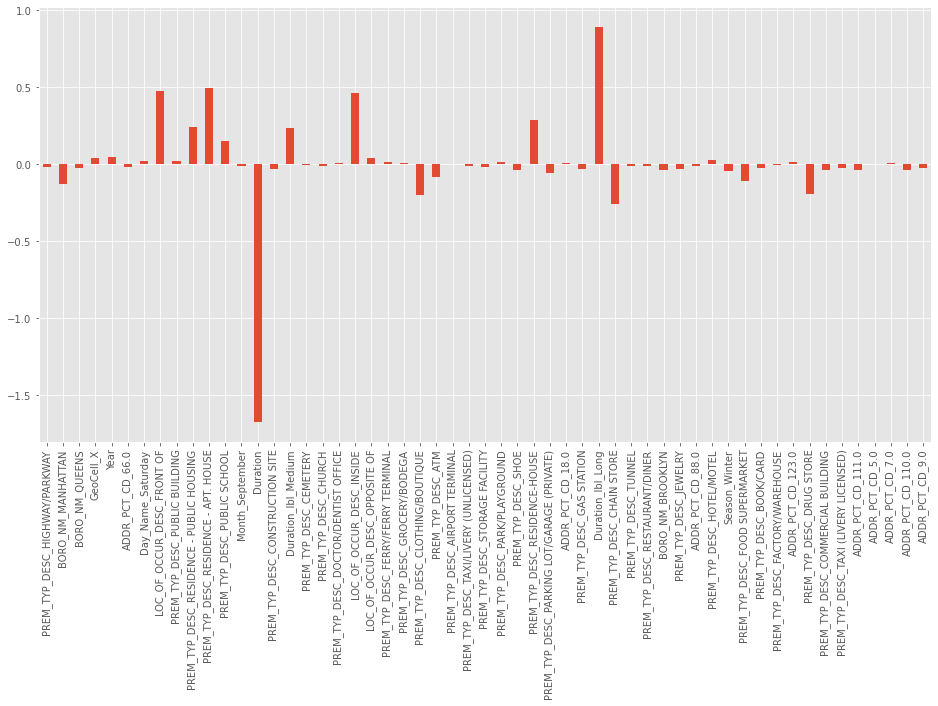

In [47]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=X_sm.columns)
weights.plot(kind='bar', figsize = (16,8))  #added figsize - trying to see if it expands the view
plt.show()

In [48]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import *
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.73      0.63      0.67     73237
           1       0.67      0.77      0.72     72897

    accuracy                           0.70    146134
   macro avg       0.70      0.70      0.69    146134
weighted avg       0.70      0.70      0.69    146134



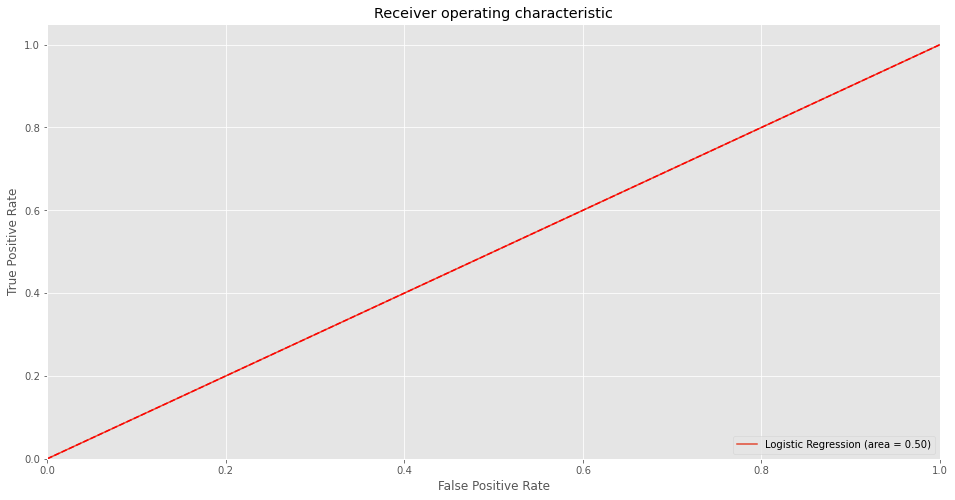

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr_clf.predict_proba(X_test)[:,1])
plt.figure(figsize = (16,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Holdout Testing

In [64]:
#test model against the holdout set
holdout = pd.read_csv('Hold_Out_Set.csv')

In [65]:
#check for nulls
holdout.isnull().values.any()

False

In [66]:
# perform one-hot encoding of the categorical data on 'JURIS_DESC','BORO_NM','LOC_OF_OCCUR_DESC',
#'ADDR_PCT_CD','PREM_TYP_DESC','Day_Name','Month','Duration_lbl','Season','Daytime'
tmp_df = pd.get_dummies(holdout.JURIS_DESC,prefix='JURIS_DESC')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.BORO_NM,prefix='BORO_NM')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.LOC_OF_OCCUR_DESC,prefix='LOC_OF_OCCUR_DESC')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.ADDR_PCT_CD,prefix='ADDR_PCT_CD')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.PREM_TYP_DESC,prefix='PREM_TYP_DESC')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.Day_Name,prefix='Day_Name')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.Month,prefix='Month')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.Duration_lbl,prefix='Duration_lbl')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.Season,prefix='Season')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(holdout.Daytime,prefix='Daytime')
holdout = pd.concat((holdout,tmp_df),axis=1) # add back into the dataframe

In [67]:
#Now we drop the original variables
if 'JURIS_DESC' in holdout:    
    del holdout['JURIS_DESC'] # get rid of the original category as it is now one-hot encoded
if 'BORO_NM' in holdout:    
    del holdout['BORO_NM'] # get rid of the original category as it is now one-hot encoded
if 'LOC_OF_OCCUR_DESC' in holdout:    
    del holdout['LOC_OF_OCCUR_DESC'] # get rid of the original category as it is now one-hot encoded
if 'ADDR_PCT_CD' in holdout:    
    del holdout['ADDR_PCT_CD'] # get rid of the original category as it is now one-hot encoded
if 'PREM_TYP_DESC' in holdout:    
    del holdout['PREM_TYP_DESC'] # get rid of the original category as it is now one-hot encoded
if 'Day_Name' in holdout:    
    del holdout['Day_Name'] # get rid of the original category as it is now one-hot encoded
if 'Month' in holdout:    
    del holdout['Month'] # get rid of the original category as it is now one-hot encoded
if 'Duration_lbl' in holdout:    
    del holdout['Duration_lbl'] # get rid of the original category as it is now one-hot encoded
if 'Season' in holdout:    
    del holdout['Season'] # get rid of the original category as it is now one-hot encoded
if 'Daytime' in holdout:    
    del holdout['Daytime'] # get rid of the original category as it is now one-hot encoded

In [68]:
#Now I want to pare down the variables - replicating the original adjustment cutting off at  |.03|%
holdout = holdout[[ 'PREM_TYP_DESC_HIGHWAY/PARKWAY', 'BORO_NM_MANHATTAN', 'BORO_NM_QUEENS', 'GeoCell_X', 'Year',
          'ADDR_PCT_CD_66.0', 'Day_Name_Saturday', 'LOC_OF_OCCUR_DESC_FRONT OF', 'PREM_TYP_DESC_PUBLIC BUILDING', 
          'PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING', 'PREM_TYP_DESC_RESIDENCE - APT. HOUSE', 
          'PREM_TYP_DESC_PUBLIC SCHOOL', 'Month_September', 'Duration', 'PREM_TYP_DESC_CONSTRUCTION SITE',
          'Duration_lbl_Medium', 'PREM_TYP_DESC_CEMETERY', 'PREM_TYP_DESC_CHURCH', 'PREM_TYP_DESC_DOCTOR/DENTIST OFFICE',
          'LOC_OF_OCCUR_DESC_INSIDE', 'LOC_OF_OCCUR_DESC_OPPOSITE OF', 'PREM_TYP_DESC_FERRY/FERRY TERMINAL',
          'PREM_TYP_DESC_GROCERY/BODEGA', 'PREM_TYP_DESC_CLOTHING/BOUTIQUE', 'PREM_TYP_DESC_ATM', 'PREM_TYP_DESC_AIRPORT TERMINAL',  'PREM_TYP_DESC_TAXI/LIVERY (UNLICENSED)',  'PREM_TYP_DESC_STORAGE FACILITY', 
          'PREM_TYP_DESC_PARK/PLAYGROUND', 'PREM_TYP_DESC_SHOE', 'PREM_TYP_DESC_RESIDENCE-HOUSE', 
          'PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE)', 'ADDR_PCT_CD_18.0', 'PREM_TYP_DESC_GAS STATION',
          'Duration_lbl_Long', 'PREM_TYP_DESC_CHAIN STORE', 'PREM_TYP_DESC_TUNNEL', 'PREM_TYP_DESC_RESTAURANT/DINER',          'BORO_NM_BROOKLYN',  'PREM_TYP_DESC_JEWELRY',  'ADDR_PCT_CD_88.0',  'PREM_TYP_DESC_HOTEL/MOTEL', 
          'Season_Winter', 'PREM_TYP_DESC_FOOD SUPERMARKET', 'PREM_TYP_DESC_BOOK/CARD', 'PREM_TYP_DESC_FACTORY/WAREHOUSE',          'ADDR_PCT_CD_123.0',  'PREM_TYP_DESC_DRUG STORE',  'PREM_TYP_DESC_COMMERCIAL BUILDING', 
          'PREM_TYP_DESC_TAXI (LIVERY LICENSED)', 'ADDR_PCT_CD_111.0', 'ADDR_PCT_CD_5.0', 'ADDR_PCT_CD_7.0', 
          'ADDR_PCT_CD_110.0', 'ADDR_PCT_CD_9.0','y']]

In [69]:
holdout.head()

,PREM_TYP_DESC_HIGHWAY/PARKWAY,BORO_NM_MANHATTAN,BORO_NM_QUEENS,GeoCell_X,Year,ADDR_PCT_CD_66.0,Day_Name_Saturday,LOC_OF_OCCUR_DESC_FRONT OF,PREM_TYP_DESC_PUBLIC BUILDING,PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING,...,ADDR_PCT_CD_123.0,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_TAXI (LIVERY LICENSED),ADDR_PCT_CD_111.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_9.0,y
0,0,0,0,7.0,2015.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,6.0,2014.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,6.0,2014.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,9.0,2014.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,8.0,2014.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [70]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'y' in holdout:
    y = holdout['y'].values # get the labels we want
    del holdout['y'] # get rid of the class label
    X = holdout.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn

In [71]:
from sklearn.preprocessing import StandardScaler

#scl_obj = StandardScaler()

holdout_test_scaled = scl_obj.transform(X) # apply those means and std to the test set (without snooping at the test set values)

y_holdout_hat = lr_clf.predict(holdout_test_scaled) # get test set precitions

acc = mt.accuracy_score(y,y_holdout_hat)
conf = mt.confusion_matrix(y,y_holdout_hat)
print('accuracy:', acc )
print(conf )

accuracy: 0.6710571097951127
[[25532 15036]
 [ 4294 13902]]


In [72]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import *
print(classification_report(y,y_holdout_hat))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73     40568
           1       0.48      0.76      0.59     18196

    accuracy                           0.67     58764
   macro avg       0.67      0.70      0.66     58764
weighted avg       0.74      0.67      0.68     58764



We compared the test, training and holdout variable metrics to evaluation overall model performance

|Metric|Training/Test Set|Holdout Set|
|---|:-:|:-:|
|Accuracy|70%|67%|
|Precision|70%|67%|
Recall|70%|70%|